<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i

In [2]:
my_list = [1, 2, 3, 4, 5]


In [3]:
gen = output_from_list_generator(my_list)


In [4]:
print(next(gen))


1


In [5]:
print(next(gen))


2


In [6]:
print(next(gen))


3


In [7]:
print(next(gen))


4


In [8]:
print(next(gen))


5


In [9]:
print(next(gen))


StopIteration: 

從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值
我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [10]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [11]:
gen = inf_loop_generator(my_list)


In [12]:
print(next(gen))


1


In [13]:
print(next(gen))


2


In [14]:
print(next(gen))


3


In [15]:
print(next(gen))


4


In [16]:
print(next(gen))


5


In [17]:
print(next(gen))


1



上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [18]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)

            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [19]:
from keras.datasets import cifar10


In [20]:
(x_train, x_test), (y_train, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:

def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = x_test[indexs: indexs+batch_size]
            yield images, labels

In [22]:
cifar_gen = cifar_generator(x_train)


In [23]:
images, labels = next(cifar_gen)


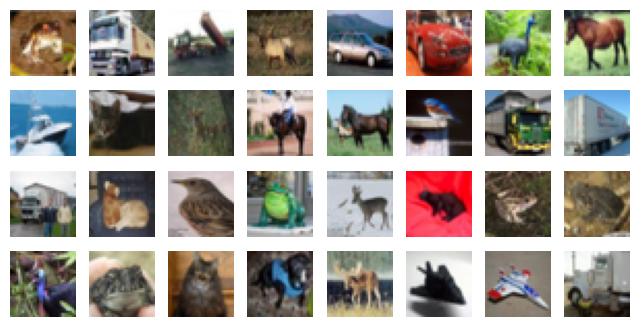

In [24]:
img_combine(images)


In [25]:
images, labels = next(cifar_gen)


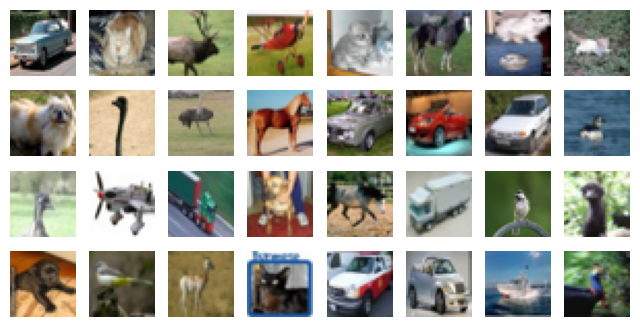

In [26]:
img_combine(images)


In [27]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import warnings

In [28]:

batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
# 將資料攤平成一維資料

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
50000 train samples
10000 test samples


In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from sklearn.utils import shuffle
def my_generator(x, y, batch_size):
    while True:
        for indexs in range(0, len(x), batch_size): # 讓 idx 從 0 開始，一次增加 batch size。假設 batch_size=32, idx = 0, 32, 64, 96, ....
            batch_x, batch_y = x[indexs:indexs+batch_size], y[indexs:indexs+batch_size]
            yield batch_x, batch_y
        x, y = shuffle(x, y) # loop 結束後，將資料順序打亂再重新循環

In [31]:
train_generator = my_generator(x_train, y_train, batch_size) # 建立好我們寫好的 generator

# Use model.fit instead of model.fit_generator
history = model.fit(train_generator,
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.2738 - loss: 1.9821 - val_accuracy: 0.4659 - val_loss: 1.4549
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4827 - loss: 1.4462 - val_accuracy: 0.5865 - val_loss: 1.1781
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5656 - loss: 1.2248 - val_accuracy: 0.6372 - val_loss: 1.0361
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6188 - loss: 1.0792 - val_accuracy: 0.6616 - val_loss: 0.9502
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6589 - loss: 0.9735 - val_accuracy: 0.6523 - val_loss: 0.9908
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6970 - loss: 0.8789 - val_accuracy: 0.7262 - val_loss: 0.7774
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7226 - loss: 0.7982 - val_accuracy: 0.6747 - val_loss: 0.9896
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7389 - loss: 0.7507 - val_acc